In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns


import matplotlib
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px

In [4]:
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import *
init_notebook_mode(connected=True)

In [5]:
df = pd.read_csv('./olympics.csv')

In [6]:
mask_Men = df.Gender == "Men"
df_Men = df[mask_Men]
df_Women = df[~mask_Men]

df_Men_group = df_Men.groupby(['Year','Sport','Country','Gender','Medal']).Athlete.count().reset_index()
df_Women_group = df_Women.groupby(['Year','Sport','Country','Gender','Medal']).Athlete.count().reset_index()

def rank_per_year(dfx):
    year_list = sorted(dfx.Year.unique())
    df_ret = pd.DataFrame()
    for yr in year_list:
        yr_mask = dfx.Year == yr
        dfx_total_count = (
            dfx[yr_mask]
            .assign(Gold = lambda df1: df1[df1.Medal =='Gold'].Athlete)
            .assign(Silver = lambda df1: df1[df1.Medal =='Silver'].Athlete)
            .assign(Bronze = lambda df1: df1[df1.Medal =='Bronze'].Athlete)
            .groupby(['Country','Sport']).Athlete.sum().reset_index()
            .sort_values(['Athlete'],ascending=False).rename(columns= {'Athlete' : 'MedalCount'})
            .assign(Year = yr)
            .merge(dfx[yr_mask][dfx[yr_mask].Medal =='Gold'],left_on=['Year','Country','Sport'],right_on=['Year','Country','Sport'],how='outer')
            .rename(columns={'Athlete' : 'Gold'}).drop(['Gender','Medal'],axis=1).fillna(0)
            .merge(dfx[yr_mask][dfx[yr_mask].Medal =='Silver'],left_on=['Year','Country','Sport'],right_on=['Year','Country','Sport'],how='outer')
            .rename(columns={'Athlete' : 'Silver'}).drop(['Gender','Medal'],axis=1).fillna(0)
            .merge(dfx[yr_mask][dfx[yr_mask].Medal =='Bronze'],left_on=['Year','Country','Sport'],right_on=['Year','Country','Sport'],how='outer')
            .rename(columns={'Athlete' : 'Bronze'}).drop(['Gender','Medal'],axis=1).fillna(0)
                       
        )       
        df_ret = (df_ret
                  .append( dfx_total_count
                          .assign(position = [int(i) for i in range(1,dfx_total_count.shape[0]+1)])
                          .assign(position = lambda dfr : dfr.position.astype(int))
                          
                         )

                 )
    return df_ret.loc[:,['Year','Country','Sport','Gold','Silver','Bronze','MedalCount','position']]

df_Men_group_ranked = rank_per_year(df_Men_group)      
df_Women_group_ranked = rank_per_year(df_Women_group)      


In [14]:
wmen=df_Women.groupby('Year')['Medal'].count().reset_index()

In [16]:
men


,Year,Medal
0,1924,112
1,1928,83
2,1932,110
3,1936,99
4,1948,125
5,1952,118
6,1956,123
7,1960,108
8,1964,139
9,1968,153


In [216]:
df_Men_group_ranked[df_Men_group_ranked.Year == 1924].head(2)

,Year,Country,Sport,Gold,Silver,Bronze,MedalCount,position
0,1924,United Kingdom,Ice Hockey,0.0,0.0,12.0,12,1
1,1924,United States,Ice Hockey,0.0,10.0,0.0,10,2


In [217]:
df_Women_group_ranked[df_Women_group_ranked.Year == 1924]

,Year,Country,Sport,Gold,Silver,Bronze,MedalCount,position
0,1924,Austria,Skating,2.0,0.0,0.0,2,1
1,1924,Finland,Skating,0.0,1.0,0.0,1,2
2,1924,France,Skating,0.0,0.0,1.0,1,3
3,1924,United Kingdom,Skating,0.0,0.0,1.0,1,4
4,1924,United States,Skating,0.0,1.0,0.0,1,5


In [224]:
(df_Men_group_ranked
.merge(df_Women_group_ranked,left_on = ['Year','Country','Sport'],right_on = ['Year','Country','Sport'],suffixes=['_men','_women'], how='outer')
.sort_values(by=['Year','position_men','position_women'])
.fillna(0)
.assign(total_medalCount = lambda df : df.MedalCount_women + df.MedalCount_men)
.loc[:,['Year','Country','Sport','total_medalCount','MedalCount_men','MedalCount_women']]
)

,Year,Country,Sport,total_medalCount,MedalCount_men,MedalCount_women
0,1924,United Kingdom,Ice Hockey,12.0,12.0,0.0
1,1924,United States,Ice Hockey,10.0,10.0,0.0
2,1924,Norway,Skiing,10.0,10.0,0.0
3,1924,Canada,Ice Hockey,9.0,9.0,0.0
4,1924,Finland,Skating,10.0,9.0,1.0
...,...,...,...,...,...,...
801,2014,United Kingdom,Skiing,1.0,0.0,1.0
802,2014,United Kingdom,Bobsleigh,1.0,0.0,1.0
803,2014,Switzerland,Biathlon,1.0,0.0,1.0
804,2014,Slovenia,Biathlon,1.0,0.0,1.0


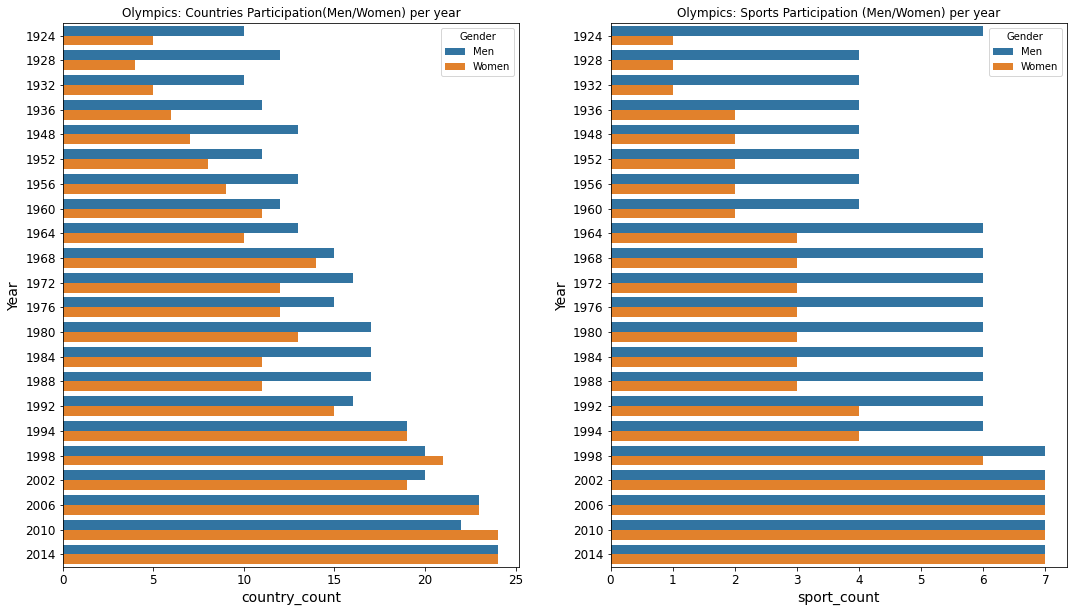

In [161]:
#### count of coutries participated every year
fig, ax = plt.subplots(ncols=2,figsize=(18,10))
sns.barplot(
data = df.groupby(['Year','Gender']).Country.unique().reset_index().assign(country_count = lambda dfy : [len(x) for x in dfy.Country.tolist()]),
y = 'Year',
x = 'country_count',
orient = 'h',
hue = 'Gender',
ax = ax[0]
)
ax[0].set_title('Olympics: Countries Participation(Men/Women) per year')

sns.barplot(
data = df.groupby(['Year','Gender']).Sport.unique().reset_index().assign(sport_count = lambda dfy : [len(x) for x in dfy.Sport.tolist()]),
y = 'Year',
hue = 'Gender',
x = 'sport_count',
orient = 'h',
ax = ax[1]
)

ax[1].set_title('Olympics: Sports Participation (Men/Women) per year')
plt.show()


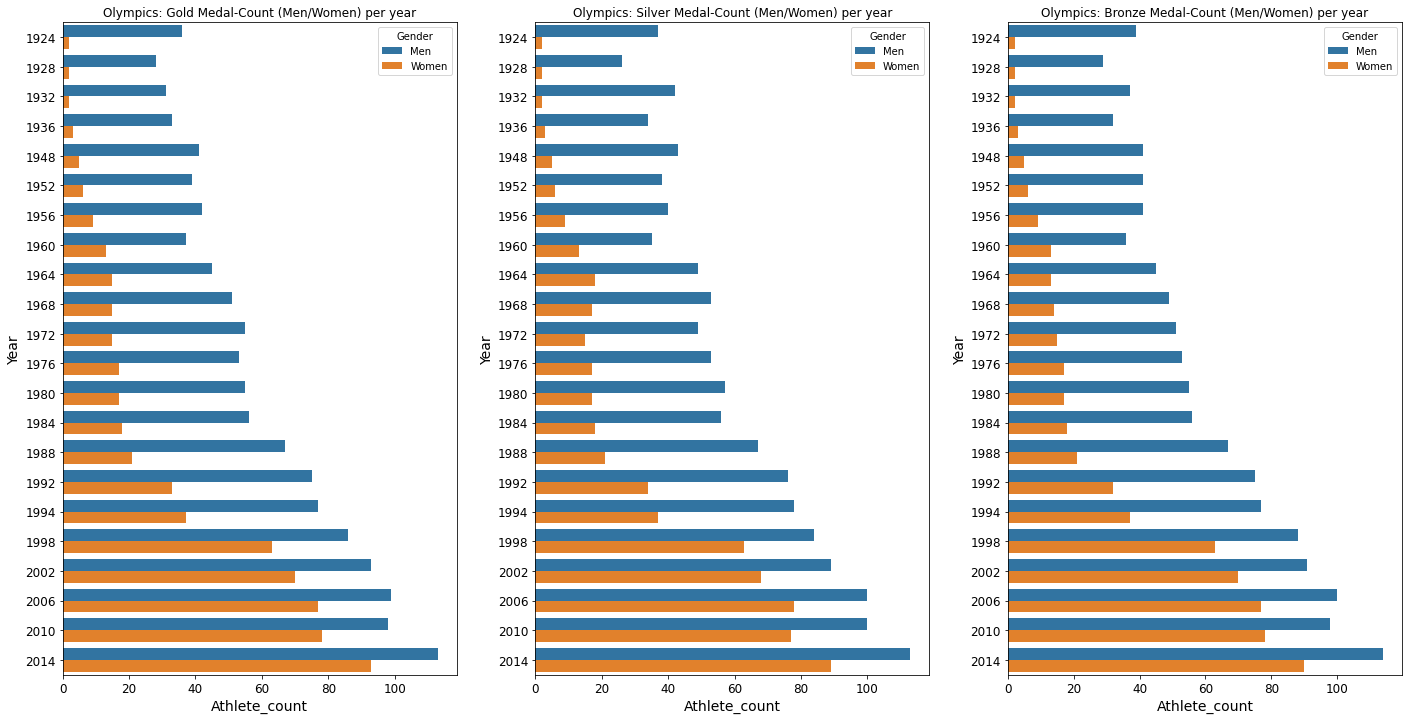

In [172]:
fig, ax = plt.subplots(ncols=3,figsize=(24,12))

medal_gender_total_df = df.groupby(['Year','Medal','Gender']).Athlete.count().reset_index().rename(columns = {'Athlete' : 'Athlete_count'})
medal_total_df = df.groupby(['Year','Medal']).Athlete.count().reset_index().rename(columns = {'Athlete' : 'Athlete_count'})

sns.barplot(
data = medal_gender_total_df[medal_gender_total_df.Medal == 'Gold'].drop(['Medal'],axis=1),
y = 'Year',
x = 'Athlete_count',
hue = 'Gender',
orient = 'h',
ax = ax[0]
)
ax[0].set_title('Olympics: Gold Medal-Count (Men/Women) per year')

sns.barplot(
data = medal_gender_total_df[medal_gender_total_df.Medal == 'Silver'].drop(['Medal'],axis=1),
y = 'Year',
x = 'Athlete_count',
hue = 'Gender',
orient = 'h',
ax = ax[1]
)
ax[1].set_title('Olympics: Silver Medal-Count (Men/Women) per year')

sns.barplot(
data = medal_gender_total_df[medal_gender_total_df.Medal == 'Bronze'].drop(['Medal'],axis=1),
y = 'Year',
x = 'Athlete_count',
hue = 'Gender',
orient = 'h',
ax = ax[2]
)
ax[2].set_title('Olympics: Bronze Medal-Count (Men/Women) per year')

plt.show()

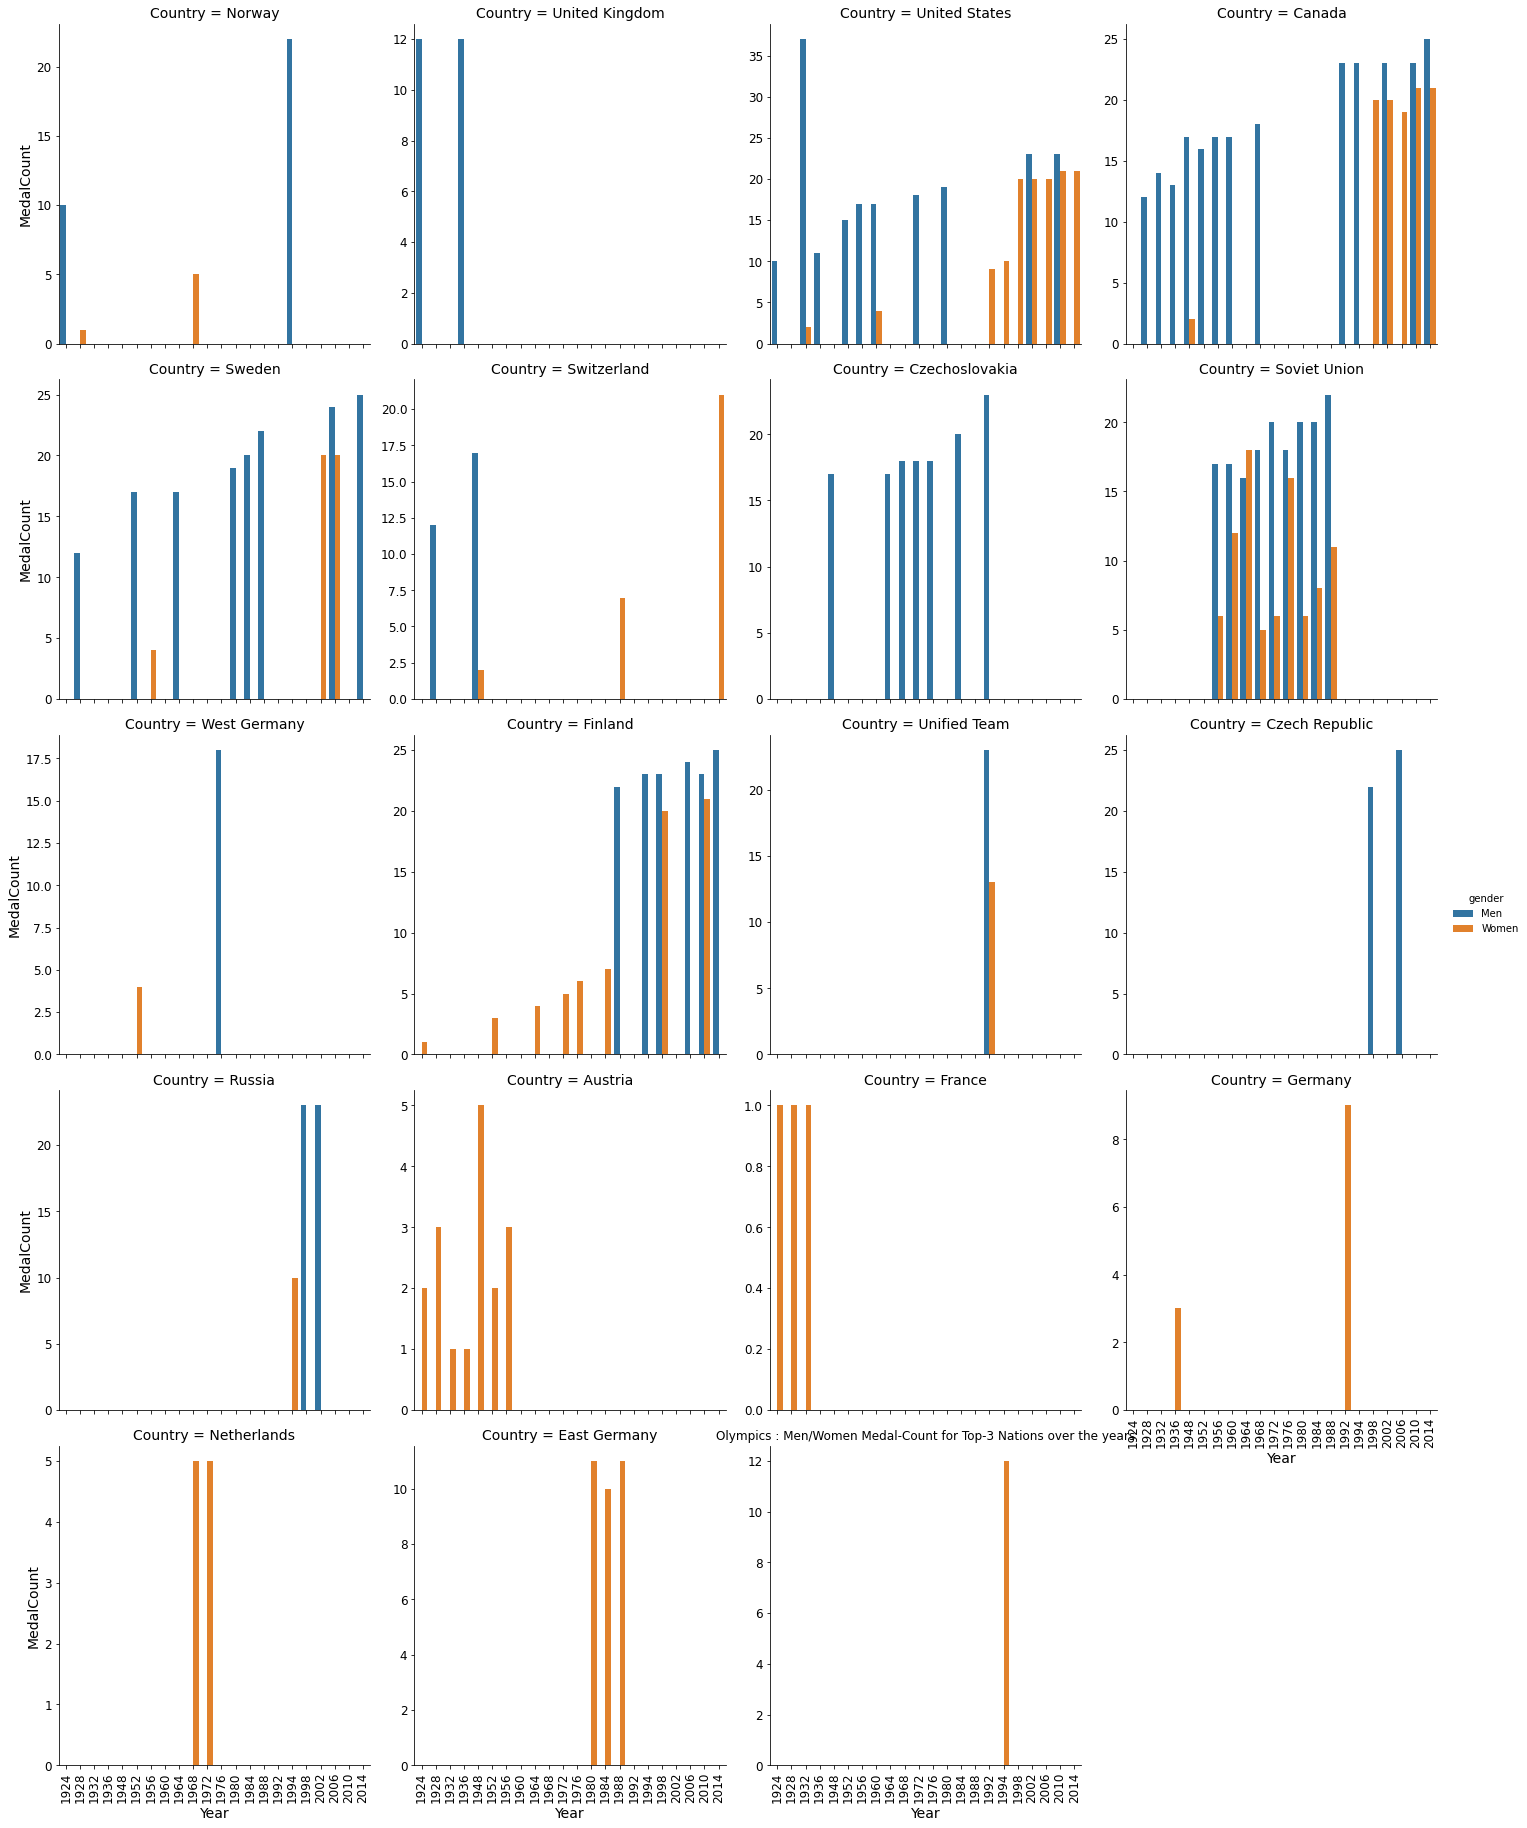

In [288]:
chart = sns.catplot(
    data  = (df_Men_group_ranked[df_Men_group_ranked.position <= 3]
    .reset_index(drop=True)
    .groupby(['Year','Country'])
    .MedalCount.sum()
    .reset_index()
    .assign(gender = 'Men')
    .append(
        (df_Women_group_ranked[df_Women_group_ranked.position <= 3]
            .reset_index(drop=True)
            .groupby(['Year','Country'])
            .MedalCount.sum()
            .reset_index()
            .assign(gender = 'Women'))
        )
    ),
    y = 'MedalCount',
    orient = 'v',
    x = 'Year',
    hue = 'gender',
    col = 'Country', col_wrap = 4,
    kind  ='bar',
    sharey=False, sharex=True, margin_titles=True,
)
chart.set_xticklabels(rotation=90)
plt.title('Olympics : Men/Women Medal-Count for Top-3 Nations over the years')
plt.show()

In [285]:
### Add couple more to show Sport domindation too

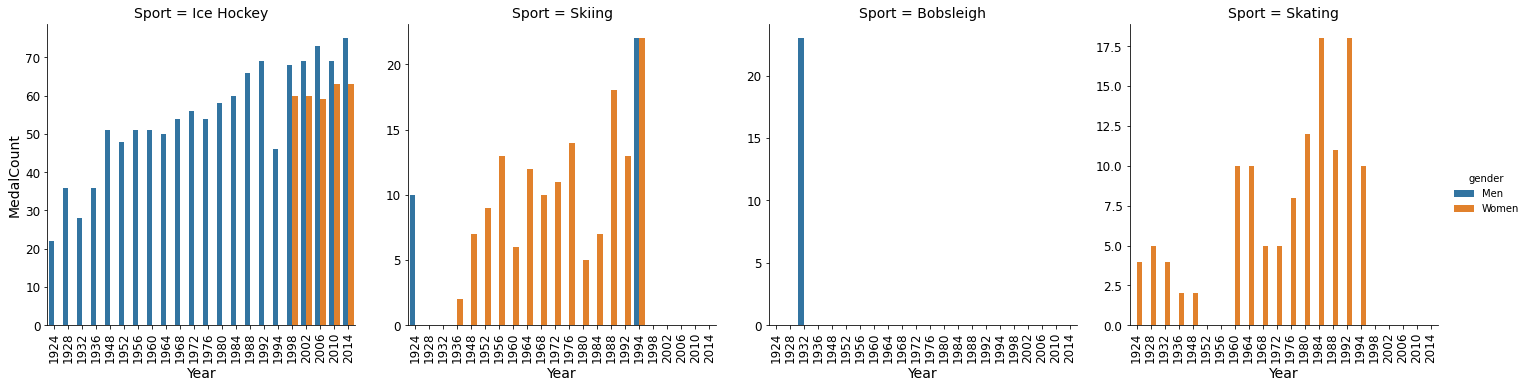

In [290]:
chart = sns.catplot(
    data  = (df_Men_group_ranked[df_Men_group_ranked.position <= 3]
    .reset_index(drop=True)
    .groupby(['Year','Sport'])
    .MedalCount.sum()
    .reset_index()
    .assign(gender = 'Men')
    .append(
        (df_Women_group_ranked[df_Women_group_ranked.position <= 3]
            .reset_index(drop=True)
            .groupby(['Year','Sport'])
            .MedalCount.sum()
            .reset_index()
            .assign(gender = 'Women'))
        )
    ),
    y = 'MedalCount',
    orient = 'v',
    x = 'Year',
    hue = 'gender',
    col = 'Sport', col_wrap = 4,
    kind  ='bar',
    sharey=False, sharex=True, margin_titles=True,
)
chart.set_xticklabels(rotation=90)
#plt.title('Olympics : Men/Women Medal-Count by Top-3 Nations in different Sports')
plt.show()

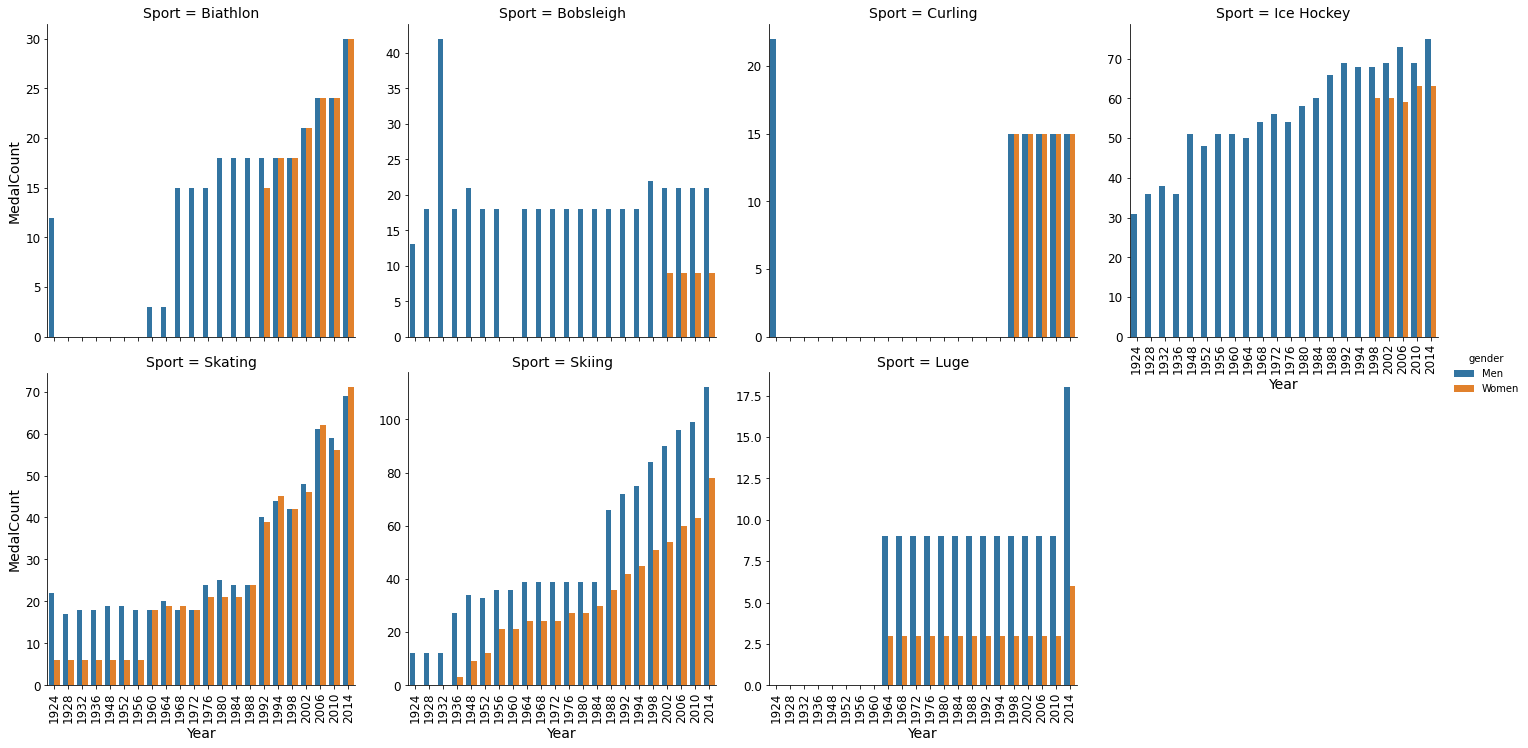

In [291]:
chart = sns.catplot(
    data  = (df_Men_group_ranked
    .reset_index(drop=True)
    .groupby(['Year','Sport'])
    .MedalCount.sum()
    .reset_index()
    .assign(gender = 'Men')
    .append(
        (df_Women_group_ranked
            .reset_index(drop=True)
            .groupby(['Year','Sport'])
            .MedalCount.sum()
            .reset_index()
            .assign(gender = 'Women'))
        )
    ),
    y = 'MedalCount',
    orient = 'v',
    x = 'Year',
    hue = 'gender',
    col = 'Sport', col_wrap = 4,
    kind  ='bar',
    sharey=False, sharex=True, margin_titles=True,
)
chart.set_xticklabels(rotation=90)
#plt.title('Olympics : Men/Women Medal-Count by Top-3 Nations in different Sports')
plt.show()